# CNN + LSTM, seperate eingabe daten, sliding window

In [3]:
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, LSTM, TimeDistributed, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, LSTM, TimeDistributed, Input, concatenate, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [5]:
load_path = '/home/scc/maite.kuester/dlss/240829_dlss_data.pkl'

#load data
with open(load_path, 'rb') as f:
    X_images_sequences, X_socio_sequences, y_labels_sequences = pickle.load(f)

In [6]:
window_size = 10

# convert the lists to numpy arrays
X_images_sequences = np.array(X_images_sequences)
X_socio_sequences = np.array(X_socio_sequences)
y_labels_sequences = np.array(y_labels_sequences)

# normalize the socio-economic data
scaler = StandardScaler()
X_socio_sequences = scaler.fit_transform(X_socio_sequences.reshape(-1, X_socio_sequences.shape[-1])).reshape(X_socio_sequences.shape)
y_labels_sequences = scaler.fit_transform(y_labels_sequences.reshape(-1, 1)).flatten()

# prepare data for training
X_images_sequences = X_images_sequences.reshape((X_images_sequences.shape[0], window_size, 256, 256, 1))

# split into training and test data
X_images_train, X_images_test, X_socio_train, X_socio_test, y_train, y_test = train_test_split(
    X_images_sequences, X_socio_sequences, y_labels_sequences, test_size=0.1, random_state=42
)

In [7]:
#model architecture
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

input_images = Input(shape=(window_size, 256, 256, 1))

#CNN layers with batch normalization 
x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))(input_images)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(x)
x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(x)
x = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(x)
x = TimeDistributed(Flatten())(x)

#LSTM layers on image features
x = LSTM(50, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.01))(x)
x = LSTM(50, activation='tanh', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x) 

input_socio = Input(shape=(window_size, X_socio_train.shape[2]))

#LSTM layer on socio-economic data 
y = LSTM(50, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.01))(input_socio)
y = LSTM(50, activation='tanh', kernel_regularizer=l2(0.01))(y)
y = Dropout(0.5)(y)  

combined = concatenate([x, y])

#fully connected layers with dropout and L2 regularization
z = Dense(50, activation='relu', kernel_regularizer=l2(0.01))(combined)
z = Dropout(0.5)(z)  
output = Dense(1)(z)

model = Model(inputs=[input_images, input_socio], outputs=output)

#compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

#summarize the model
model.summary()

#callbacks for dynamic learning rate adjustment and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#training
history = model.fit(
    [X_images_train, X_socio_train], y_train,
    validation_data=([X_images_test, X_socio_test], y_test),
    epochs=100,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping]
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 256, 256, 1)]    0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 10, 256, 256, 32)     320       ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (None, 10, 256, 256, 32)     128       ['time_distributed[0][0]']    
 stributed)                                                                                       
                                                                                              

In [9]:
from sklearn.metrics import mean_squared_error

#evaluate model 
test_loss = model.evaluate([X_images_test, X_socio_test], y_test, batch_size=32)
print(f"Test Loss: {test_loss}")

predictions = model.predict([X_images_test, X_socio_test])
for i in range(5):
    print(f"Prediction: {predictions[i]}, Actual: {y_test[i]}")

#calculate the Mean Squared Error (MSE) using scikit-learn
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (MSE): {mse}")

7/7 [==============================] - 3s 421ms/step - loss: 0.3080
Test Loss: 0.3079783618450165
7/7 [==============================] - 3s 407ms/step
Prediction: [0.999391], Actual: 0.7372259943818524
Prediction: [-0.76972115], Actual: -1.1833789424381844
Prediction: [0.37490082], Actual: -0.09960901380402074
Prediction: [-0.67391264], Actual: -0.4837300011680281
Prediction: [-1.0205927], Actual: -1.2382533692044713
Mean Squared Error (MSE): 0.1667947692529197


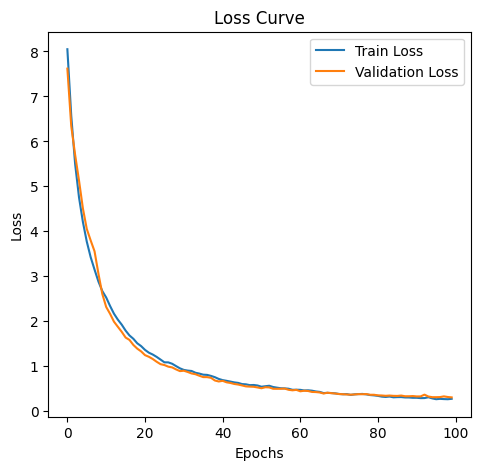

In [10]:
#visualizing the learning curves
plt.figure(figsize=(12, 5))

#loss curve for training and validation
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()